In [1]:
import sys
sys.path.append('../')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nnhealpix.layers
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pl

In [2]:
%load_ext autoreload
%autoreload 2
from taunet.simulation import * 
from taunet.ncm import NoiseModel
from taunet.cnn import TauNet

TauNet: Running on perlmutter


In [3]:
taus = np.round(np.arange(0.01,0.13,5e-4),4)
cmb = CMBmap(taus,nsim=240000,verbose=False)

In [4]:
nm = NoiseModel(method='ffp8')

In [5]:
taus = cmb.tau_dis

Text(0.5, 0, '$\\tau$')

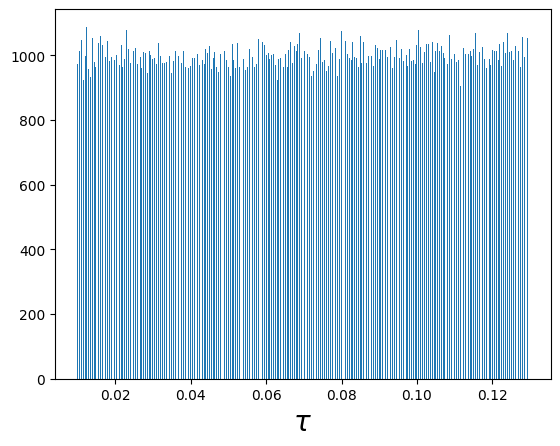

In [46]:
TAU = taus
null = plt.hist(TAU, bins=500)
plt.xlabel('$\\tau$', fontsize=20)

In [7]:
# QU_S = []
# QU_N100 = []
# QU_N143 = []
# for i in tqdm(range(1000)):
#     #QU_S.append(hp.alm2cl(hp.map2alm_spin(cmb.QU(i)*1e-6,2,lmax=48)[0]))  
#     #QU_N100.append(hp.alm2cl(hp.map2alm_spin(nm.noisemap(freq=100,idx=i,order='ring'),2,lmax=48)[0]))
#     QU_S.append(cmb.QU(i).T*1e-6)
#     QU_N100.append(nm.noisemap(freq=100,idx=i,order='ring').T)
#     QU_N143.append(nm.noisemap(freq=143,idx=i,order='ring').T)

In [8]:
# pl.dump(QU_S, open('/pscratch/sd/l/lonappan/cmb.pkl','wb'))
# del QU_S

In [9]:
# pl.dump(QU_N100, open('/pscratch/sd/l/lonappan/ffp8_N100.pkl','wb'))
# del QU_N100

In [10]:
# pl.dump(QU_N143, open('/pscratch/sd/l/lonappan/ffp8_N143.pkl','wb'))
# del QU_N143

In [11]:
QU_S = pl.load(open('/pscratch/sd/l/lonappan/cmb.pkl','rb'))

In [12]:
print(len(TAU),len(QU_S))

240000 240000


In [13]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(np.array(QU_S), TAU, test_size=0.2, random_state=42)

In [7]:
models = TauNet(nmaps=2)

2024-04-16 13:03:47.334776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 13:03:48.109651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35467 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [10]:
models.load('../Nets/cmb.keras')

In [15]:
del QU_S

In [16]:
hists = models.compile_and_fit(Xs_train,ys_train,Xs_test,ys_test)

Epoch 1/45


2024-04-16 12:03:27.605515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2024-04-16 12:03:28.556274: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6000/6000 [==============================] - 35s 5ms/step - loss: 0.0044 - mean_squared_error: 0.0025 - val_loss: 0.0015 - val_mean_squared_error: 0.0025 - lr: 0.0010
Epoch 2/45
6000/6000 [==============================] - 27s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0026 - val_loss: 9.2438e-04 - val_mean_squared_error: 0.0027 - lr: 0.0010
Epoch 3/45
6000/6000 [==============================] - 28s 5ms/step - loss: 9.6962e-04 - mean_squared_error: 0.0027 - val_loss: 7.4881e-04 - val_mean_squared_error: 0.0027 - lr: 0.0010
Epoch 4/45
6000/6000 [==============================] - 28s 5ms/step - loss: 7.1064e-04 - mean_squared_error: 0.0027 - val_loss: 5.2499e-04 - val_mean_squared_error: 0.0027 - lr: 0.0010
Epoch 5/45
6000/6000 [==============================] - 26s 4ms/step - loss: 5.9233e-04 - mean_squared_error: 0.0028 - val_loss: 5.3011e-04 - val_mean_squared_error: 0.0027 - lr: 0.0010
Epoch 6/45
6000/6000 [==============================] - 26s 4ms/step - loss: 5.2896e-04 - mea

In [17]:
models.save('cmb.keras')

In [18]:
predicts = models.predict(Xs_test)

1500/1500 [==============================] - 3s 2ms/step


In [19]:
diffs = predicts[:,0] - ys_test.flatten()
stds = np.std(diffs)

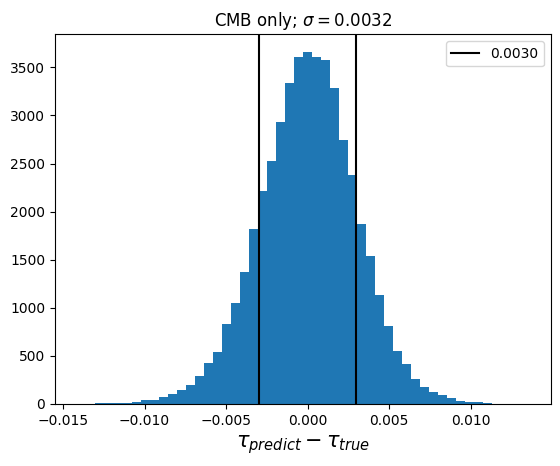

In [36]:
plt.hist(predicts[:,0] - ys_test.flatten(),bins=50)
plt.xlabel('$\\tau_{predict} - \\tau_{true}$',fontsize=15)
plt.axvline(stds,c='k',label=f'{stds:.4f}')
plt.axvline(-stds,c='k')
plt.title(f'CMB only; $\sigma=${np.mean(np.abs(predicts[:,1])):.4f}')
plt.legend()
plt.savefig('cmbonly.pdf',dpi=300,bbox_inches='tight')

In [27]:
np.mean(np.abs(predicts[:,1]))

0.003186234

In [36]:
t1 = 0.07

In [37]:
cmb_t1 = CMBmap(t1,nsim=10000,verbose=False)
cmb_T1 = []
for i in tqdm(range(10000)):
    cmb_T1.append(cmb_t1.QU(i).T*1e-6)

100%|██████████| 10000/10000 [00:48<00:00, 207.08it/s]


In [38]:
cmb_T1 = np.array(cmb_T1)

In [39]:
predicts_T1 = models.predict(cmb_T1)
stds_T1 = np.std(predicts_T1[:,0])

313/313 [==============================] - 1s 2ms/step


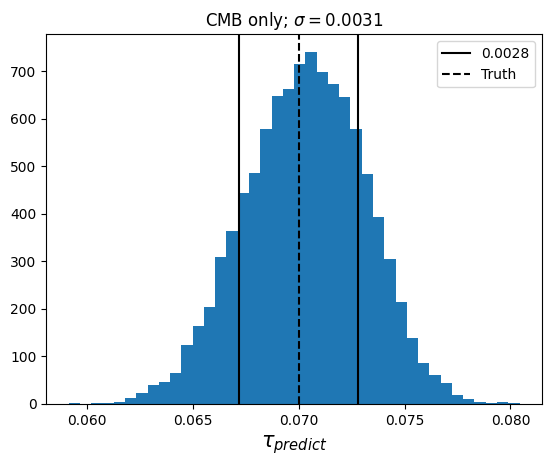

In [41]:
plt.hist(predicts_T1[:,0],bins=40)
plt.xlabel('$\\tau_{predict}$',fontsize=15)
plt.axvline(stds_T1+t1,c='k',label=f'{stds_T1:.4f}')
plt.axvline(-stds_T1+t1,c='k')
plt.axvline(t1,c='k',ls='--',label='Truth')
plt.title(f'CMB only; $\sigma=${np.mean(np.abs(predicts_T1[:,1])):.4f}')
plt.legend()
plt.savefig(f"cmbonly{str(t1).replace('.','p')}.pdf",dpi=300,bbox_inches='tight')

In [34]:
str(t1).replace('.','p')

'0p06'